In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]=="Astro"]

In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 3013 cells


In [9]:
new_sub_annotation = []
for c in obj.obs["Cell sub annotation"].tolist():
    if c in ['Astro_AMY', 'Astro_AMY_CTX', 'Astro_CTX']:
        new_sub_annotation.append('Astro_AMY_CTX')
    elif c in ['Astro_THAL_hab', 'Astro_THAL_lat', 'Astro_THAL_med']:
        new_sub_annotation.append('Astro_THAL')
    else:
        new_sub_annotation.append(c)
obj.obs["Cell sub annotation"] = new_sub_annotation
obj.obs["Cell sub annotation"] = obj.obs["Cell sub annotation"].astype("category")

Trying to set attribute `.obs` of view, copying.


#### Data preparation

In [10]:
sf.data_preparation(obj)

#### Removing general genes

In [11]:
s1 = time.time()

In [12]:
obj = sf.remove_general_genes(obj, species='mouse')

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [13]:
obj = sf.remove_housekeepingenes(obj, path="../../../data/house_keeping_genes_Mouse_cortex.txt")

#### Removing genes expressed in less than 30% within groups

In [14]:
obj = sf.remove_features_pct(obj, group_by="Cell sub annotation", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [15]:
obj = sf.remove_features_pct_2groups(obj, group_by="Cell sub annotation", pct1=0.75, pct2=0.5)

#### Revert PCA

In [16]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 1.0


In [17]:
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

#### ensemble_learning

In [18]:
s2 = time.time()

Running with XGBoost (as of now, class_weight not implemented)
[14:24:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<Figure size 432x288 with 0 Axes>

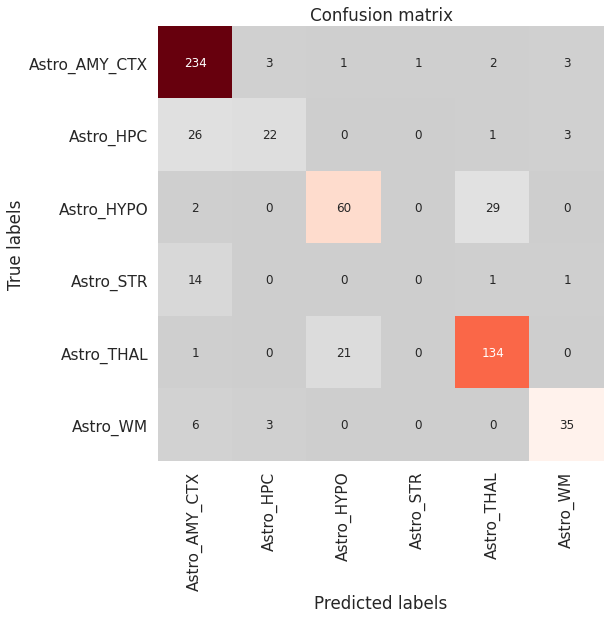

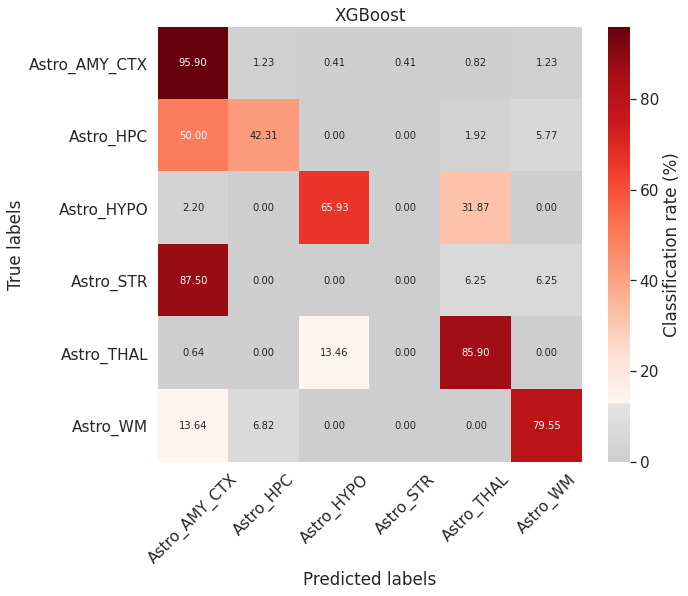

Accuracy: 0.8043117744610282: Misclassification: 0.1956882255389718
               precision    recall  f1-score   support

Astro_AMY_CTX       0.83      0.96      0.89       244
    Astro_HPC       0.79      0.42      0.55        52
   Astro_HYPO       0.73      0.66      0.69        91
    Astro_STR       0.00      0.00      0.00        16
   Astro_THAL       0.80      0.86      0.83       156
     Astro_WM       0.83      0.80      0.81        44

     accuracy                           0.80       603
    macro avg       0.66      0.62      0.63       603
 weighted avg       0.78      0.80      0.79       603



In [19]:
clf = sf.ensemble_learning(obj, group_by="Cell sub annotation", classifier="XGBoost", balance=True, verbose=True)

#### gini_importance

In [20]:
selectedGenes, selectedGenes_dict = sf.gini_importance(obj, clf, group_by="Cell sub annotation", verbose=True, restrict_top=("local", 20))

In [21]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

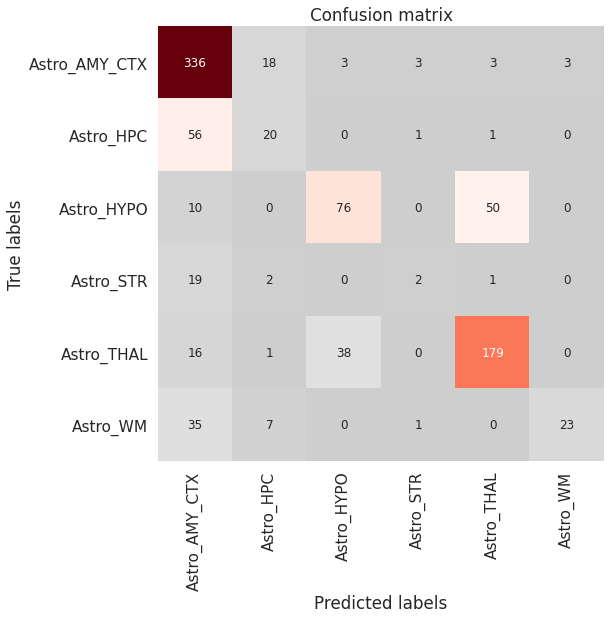

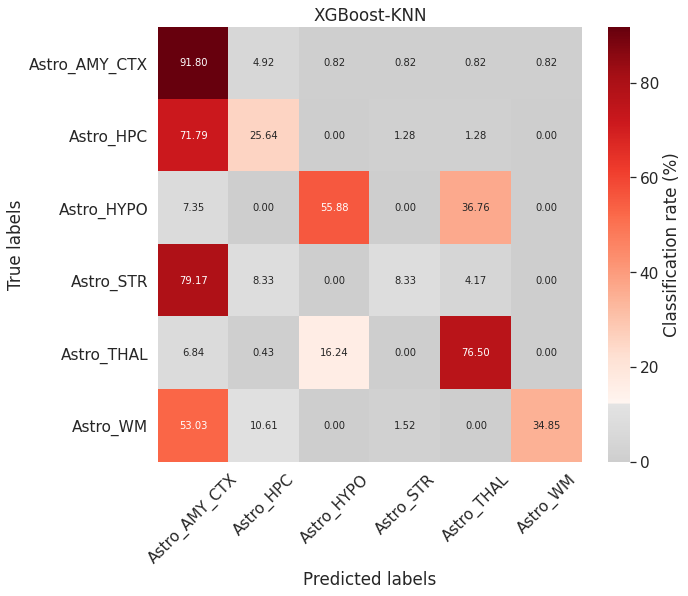

Accuracy: 0.7035398230088495: Misclassification: 0.29646017699115046
               precision    recall  f1-score   support

Astro_AMY_CTX       0.71      0.92      0.80       366
    Astro_HPC       0.42      0.26      0.32        78
   Astro_HYPO       0.65      0.56      0.60       136
    Astro_STR       0.29      0.08      0.13        24
   Astro_THAL       0.76      0.76      0.76       234
     Astro_WM       0.88      0.35      0.50        66

     accuracy                           0.70       904
    macro avg       0.62      0.49      0.52       904
 weighted avg       0.69      0.70      0.68       904



In [22]:
sf.run_classifiers(obj, group_by="Cell sub annotation", genes=selectedGenes, classifier="KNN", balance=True, title="XGBoost-KNN")

#### Sorting genes per cluster

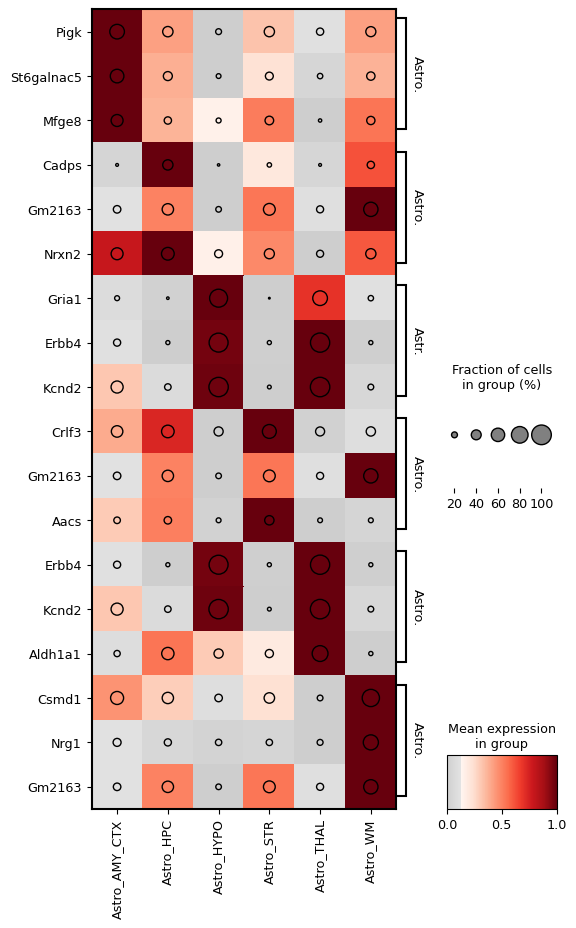

In [23]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="Cell sub annotation", top=3, figsize=(6,10))

In [24]:
e1 = time.time()

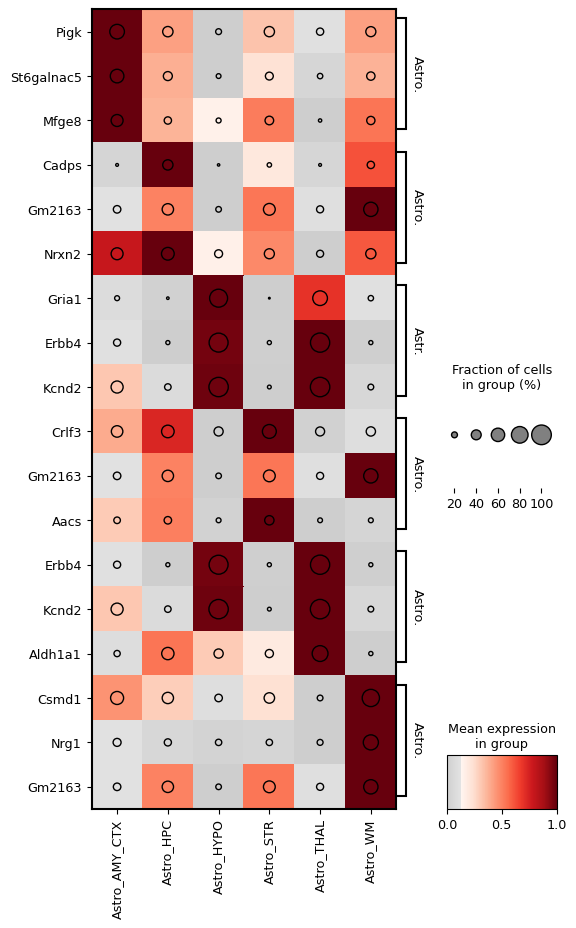

In [25]:
axs.savefig("Figures/XGBoost_top5_perGroup.pdf")

# Elapsed time

In [26]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

1266 genes across 3013 cells


In [27]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  224.8899028301239


In [28]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  202.87594890594482
